In [62]:
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt
import os
import pywt
import shutil
from sklearn.model_selection import train_test_split
from skimage import io
from glob import glob
import pickle
%matplotlib inline

In [2]:
img = cv2.imread('./Test_Images/Atif_Aslam_1.jpg')
img.shape


(1080, 1092, 3)

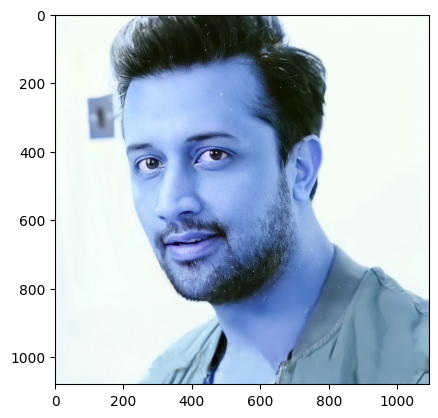

In [3]:
plt.imshow(img)

In [4]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray.shape

(1080, 1092)

In [5]:
gray

array([[252, 252, 252, ..., 253, 251, 249],
       [251, 251, 251, ..., 252, 252, 251],
       [250, 250, 250, ..., 252, 252, 252],
       ...,
       [252, 251, 249, ..., 178, 177, 177],
       [250, 250, 251, ..., 178, 177, 176],
       [243, 245, 248, ..., 177, 176, 175]], dtype=uint8)

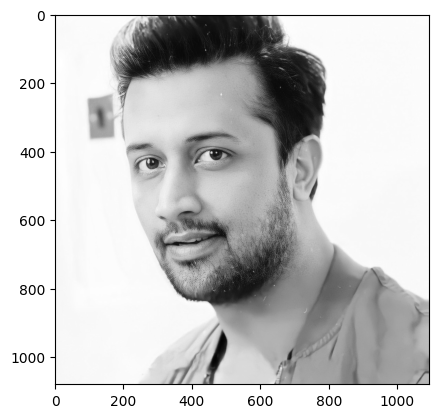

In [6]:
plt.imshow(gray, cmap='gray')

In [7]:
# Let's discuss face and eyes now

In [8]:
face_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_eye.xml')

faces = face_cascade.detectMultiScale(gray)
faces

array([[ 87, 186, 606, 606]])

In [9]:
(x,y,w,h) = faces[0]
x,y,w,h

(87, 186, 606, 606)

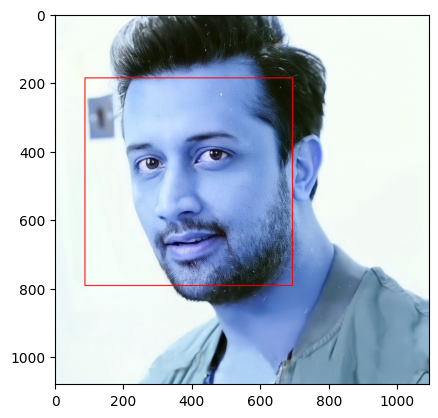

In [10]:
face_img = cv2.rectangle(img, (x,y), (x+w,y+h),(255,0,0),2)
plt.imshow(face_img)

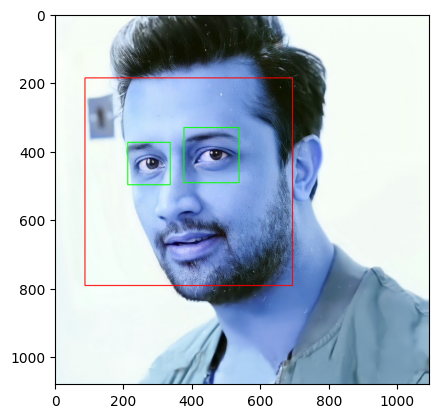

In [11]:
cv2.destroyAllWindows()
for (x,y,w,h) in faces:
    face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = face_img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
        

plt.figure()
plt.imshow(face_img, cmap='gray')
plt.show()


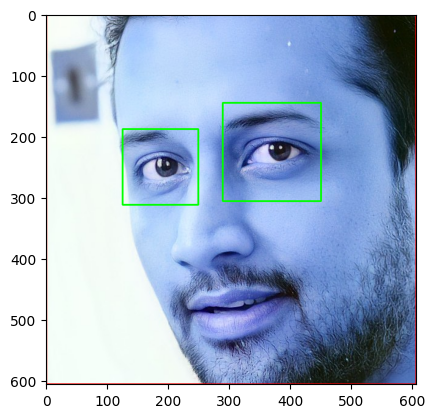

In [12]:
%matplotlib inline
plt.imshow(roi_color, cmap='gray')

In [13]:
# image_path = "./Test_Images/Atif_Aslam_1.jpg"
def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    gray2 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        roi_gray = gray2[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color


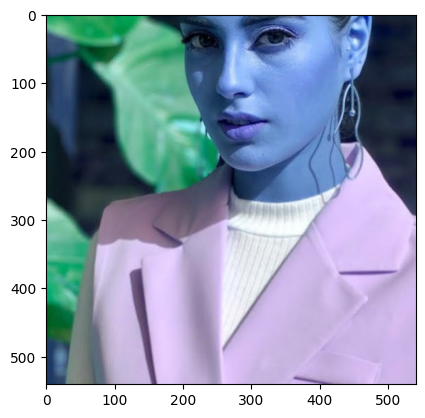

In [14]:
cropped_image = get_cropped_image_if_2_eyes('./Test_Images/Iqra_Aziz_2.jpg')
plt.imshow(cropped_image)

# Data Cleaning

We will clean all the images in which harsh code can not detect eyes and faces properly.

In [19]:
path_to_data = "./dataset/" #current directory
path_to_cr_data = "./dataset/cropped/" #Directory to store the cropped images

In [20]:
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [21]:
img_dirs

['./dataset/Atif_Aslam',
 './dataset/cropped',
 './dataset/Humayun_Saeed',
 './dataset/Iqra_Aziz',
 './dataset/Mahira_Khan',
 './dataset/Sajal_Aly']

In [18]:
import shutil
if os.path.exists(path_to_cr_data):
    shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

In [19]:
cropped_image_dirs = []
celebrity_file_names_dict = {}

for img_dir in img_dirs:
    if(img_dir=='./dataset/cropped'):
        continue
    count = 1
    celebrity_name = img_dir.split('/')[-1]
    print(celebrity_name)
    
    celebrity_file_names_dict[celebrity_name] = []
    file = glob(os.path.join(img_dir, "*.jpg"))
    for filename in file:
        roi_color = get_cropped_image_if_2_eyes(filename)
        if roi_color is not None:
            cropped_folder = path_to_cr_data + celebrity_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                print("Generating cropped images in folder: ",cropped_folder)
                
            cropped_file_name = celebrity_name + str(count) + ".png"
            cropped_file_path = cropped_folder + "/" + cropped_file_name 
            
            cv2.imwrite(cropped_file_path, roi_color)
            celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
            count += 1  

Atif_Aslam
Generating cropped images in folder:  ./dataset/cropped/Atif_Aslam
Humayun_Saeed
Generating cropped images in folder:  ./dataset/cropped/Humayun_Saeed
Iqra_Aziz
Generating cropped images in folder:  ./dataset/cropped/Iqra_Aziz
Mahira_Khan
Generating cropped images in folder:  ./dataset/cropped/Mahira_Khan
Sajal_Aly
Generating cropped images in folder:  ./dataset/cropped/Sajal_Aly


We will do manual data cleaning to remove other pictures.

# Feature Engineering 

In [37]:
def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

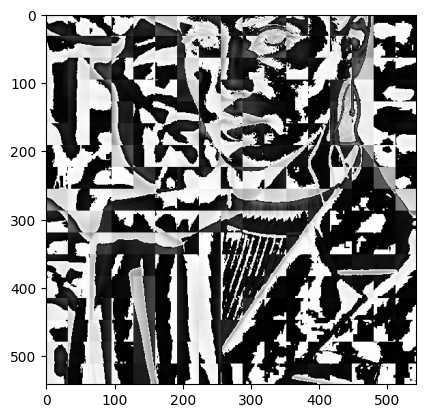

In [38]:
im_har = w2d(cropped_image,'db1',5)
plt.imshow(im_har, cmap='gray')

In [39]:
celebrity_file_names_dict

NameError: name 'celebrity_file_names_dict' is not defined

In [41]:
class_dict ={}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count+=1
class_dict

{'Atif_Aslam': 0,
 'cropped': 1,
 'Humayun_Saeed': 2,
 'Iqra_Aziz': 3,
 'Mahira_Khan': 4,
 'Sajal_Aly': 5}

# Data Augmentation

It seems our model is underfitted. Let's perform some data augmentation to rempve underfitting. 

In [ ]:
# Importing necessary functions
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img
  
# Initialising the ImageDataGenerator class.
# We will pass in the augmentation parameters in the constructor.
datagen = ImageDataGenerator(
        rotation_range = 40,
        shear_range = 0.2,
        zoom_range = 0.2,
        horizontal_flip = True,
        brightness_range = (0.5, 1.5))


# Loading a sample image 
img = load_img('./dataset/cropped/Atif_Aslam/Atif_Aslam1.png') 
# Converting the input sample image to an array
x = img_to_array(img)
# Reshaping the input image
x = x.reshape((1, ) + x.shape) 
  
# Generating and saving 5 augmented samples 
# using the above defined parameters. 
i = 0
for batch in datagen.flow(x, batch_size = 1,
                          save_to_dir ='./dataset/cropped/Atif_Aslam',  save_format ='jpg'):
    i += 1
    if i > 5:
        break

In [ ]:
for celebrity_name, training_file in celebrity_file_names_dict.items():
    for training_image in training_file:
        img = load_img(training_image) 
        if img is not None:
            x = img_to_array(img)
            # Reshaping the input image
            x = x.reshape((1, ) + x.shape) 

            # Generating and saving 5 augmented samples 
            # using the above defined parameters. 
            i = 0
            for batch in datagen.flow(x, batch_size = 1,
                                      save_to_dir ='./dataset/cropped/'+ celebrity_name,  save_format ='jpg'):
                i += 1
                if i > 20:
                    break

# Train Test Split

Images in cropped folder can be used for model training. We will use these raw images along with wavelet transformed images to train our classifier. Let's prepare X and y now.

In [69]:
celebrity_file_names_dict2 = {}
for img_dir in img_dirs:
    celebrity_name = img_dir.split('/')[-1]
    path = "./dataset/cropped/" + celebrity_name
    celebrity_file_names_dict2[celebrity_name] = glob(os.path.join(path, "*.jpg"))
celebrity_file_names_dict2

{'Atif_Aslam': ['./dataset/cropped/Atif_Aslam\\_0_1009.jpg',
  './dataset/cropped/Atif_Aslam\\_0_1015.jpg',
  './dataset/cropped/Atif_Aslam\\_0_1018.jpg',
  './dataset/cropped/Atif_Aslam\\_0_1024.jpg',
  './dataset/cropped/Atif_Aslam\\_0_1038.jpg',
  './dataset/cropped/Atif_Aslam\\_0_105.jpg',
  './dataset/cropped/Atif_Aslam\\_0_1050.jpg',
  './dataset/cropped/Atif_Aslam\\_0_1099.jpg',
  './dataset/cropped/Atif_Aslam\\_0_110.jpg',
  './dataset/cropped/Atif_Aslam\\_0_1109.jpg',
  './dataset/cropped/Atif_Aslam\\_0_1110.jpg',
  './dataset/cropped/Atif_Aslam\\_0_112.jpg',
  './dataset/cropped/Atif_Aslam\\_0_1134.jpg',
  './dataset/cropped/Atif_Aslam\\_0_1141.jpg',
  './dataset/cropped/Atif_Aslam\\_0_1161.jpg',
  './dataset/cropped/Atif_Aslam\\_0_1185.jpg',
  './dataset/cropped/Atif_Aslam\\_0_1191.jpg',
  './dataset/cropped/Atif_Aslam\\_0_1197.jpg',
  './dataset/cropped/Atif_Aslam\\_0_1205.jpg',
  './dataset/cropped/Atif_Aslam\\_0_1230.jpg',
  './dataset/cropped/Atif_Aslam\\_0_1231.jpg',
  

In [70]:
X = []
y = []

# for celebrity_name, training_file in celebrity_file_names_dict.items():
for celebrity_name, training_file in celebrity_file_names_dict2.items():
    for training_image in training_file:
        img = cv2.imread(training_image)
        if img is None:
            continue
        scaled_raw_image = cv2.resize(img, (32,32))
        img_har = w2d(img, 'db1', 5)
        scaled_img_har = cv2.resize(img_har,(32,32))
        combined_img = np.vstack((scaled_raw_image.reshape(32*32*3,1),scaled_img_har.reshape(32*32,1)))
        
        X.append(combined_img)
        y.append(class_dict[celebrity_name])


{'Atif_Aslam': 0,
 'cropped': 1,
 'Humayun_Saeed': 2,
 'Iqra_Aziz': 3,
 'Mahira_Khan': 4,
 'Sajal_Aly': 5}

In [44]:
X[0]

array([[124],
       [183],
       [255],
       ...,
       [230],
       [234],
       [ 43]], dtype=uint8)

In [45]:
y

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [46]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(3308, 4096)

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.3, random_state=42)

# Training the Model

In [48]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [49]:
pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.8942598187311178

In [50]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94       162
           2       0.99      0.84      0.91        87
           3       0.88      0.86      0.87       164
           4       1.00      0.57      0.72        44
           5       0.84      0.97      0.90       205

    accuracy                           0.89       662
   macro avg       0.93      0.84      0.87       662
weighted avg       0.90      0.89      0.89       662



In [127]:
# Let's use GridSearch

In [51]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [169]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [ ]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

In [132]:
best_estimators['svm'].score(X_test,y_test)

0.375

So, our best estimator is SVC.

In [58]:
best_estimator = SVC(kernel = 'rbf', C = 10)
best_estimator.fit(X_train, y_train)
best_estimator.score(X_test,y_test)

0.877643504531722

In [67]:
X_test[0].shape

(4096,)

In [68]:
best_estimator.predict(X_test)

array([0, 0, 3, 2, 0, 5, 3, 5, 5, 0, 4, 0, 0, 5, 0, 3, 5, 5, 5, 5, 5, 3,
       3, 5, 5, 0, 5, 5, 0, 5, 3, 0, 0, 0, 3, 3, 3, 4, 3, 5, 0, 5, 5, 5,
       5, 3, 3, 3, 5, 0, 3, 3, 2, 3, 0, 5, 2, 3, 3, 3, 5, 5, 3, 0, 0, 0,
       0, 0, 5, 3, 4, 0, 3, 5, 3, 5, 5, 0, 5, 5, 3, 0, 0, 0, 5, 5, 3, 0,
       3, 2, 4, 5, 3, 5, 3, 3, 5, 5, 0, 5, 3, 0, 2, 0, 5, 2, 0, 5, 0, 5,
       0, 0, 5, 0, 5, 2, 0, 5, 0, 0, 3, 5, 5, 0, 5, 5, 4, 3, 0, 0, 2, 4,
       2, 3, 2, 0, 5, 5, 5, 3, 5, 5, 5, 5, 2, 0, 3, 5, 5, 3, 3, 4, 4, 5,
       2, 0, 3, 3, 4, 3, 0, 5, 5, 5, 3, 5, 3, 5, 4, 0, 0, 5, 0, 5, 5, 3,
       5, 0, 0, 5, 3, 0, 0, 5, 4, 5, 5, 0, 5, 0, 5, 0, 2, 3, 5, 2, 2, 3,
       3, 3, 2, 0, 3, 0, 3, 0, 2, 3, 0, 0, 3, 0, 0, 0, 5, 0, 5, 0, 5, 5,
       5, 0, 0, 5, 0, 5, 5, 3, 3, 3, 4, 2, 4, 3, 3, 5, 3, 3, 0, 5, 5, 5,
       5, 5, 5, 5, 5, 3, 4, 5, 3, 5, 2, 5, 3, 5, 2, 5, 0, 5, 3, 5, 0, 0,
       5, 0, 5, 2, 0, 3, 3, 5, 5, 3, 3, 4, 2, 5, 3, 0, 0, 3, 5, 0, 3, 3,
       3, 5, 5, 0, 5, 5, 0, 5, 3, 3, 0, 3, 5, 3, 3,

In [59]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_estimator.predict(X_test))
cm

array([[151,   2,   5,   0,   4],
       [  4,  69,   3,   0,  11],
       [  1,   0, 137,   0,  26],
       [  4,   2,   7,  25,   6],
       [  0,   0,   6,   0, 199]], dtype=int64)

Text(95.72222222222221, 0.5, 'Truth')

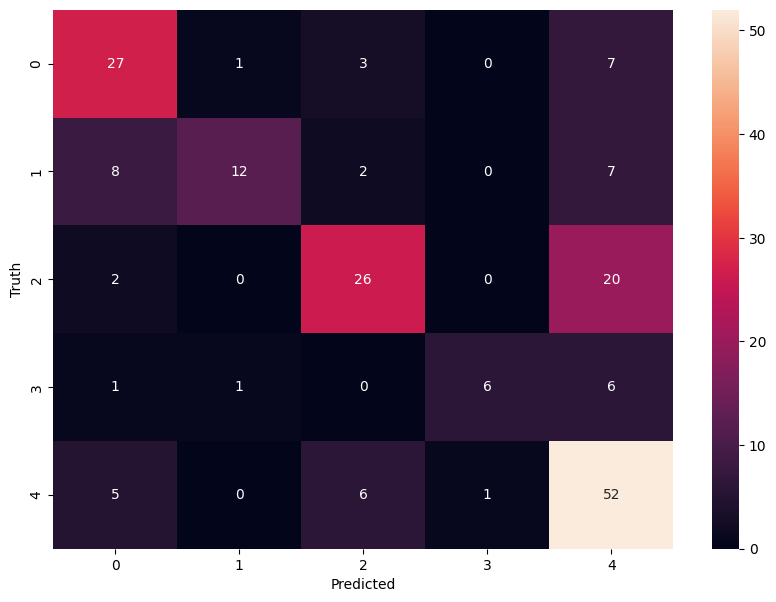

In [44]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

It seems that the data is underfitted. Let's perform some data-Augmentation.

In [60]:
# We have got accuracy of 87% after performing Data Augmentation and using SVC model.

# Loading the Model

In [63]:
pickle.dump(best_estimator,open('model.pkl','wb'))